# Imports

### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

### Importing data

In [2]:
train_data = pd.read_csv('train.csv')
# print(train_data)
test_data = pd.read_csv('test.csv') #this is a dataset without survival details - we will use this towards the end only; the model will be built based on the training dataset
# print(test_data)

# Data Cleaning

#### Creating a copy of the dataset to clean and make changes

In [3]:
model_data = train_data

In [4]:
model_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Name, Sex, Ticket, Cabin and Embarked are all non-numeric and converting them to numbers will help processing

#### The Sex and Embarked features are discrete and only have fixed values so we can map these using numbers

#### Mapping the 'Sex' feature

In [5]:
model_data['Sex_mapped'] = model_data['Sex'].replace(to_replace='female', value=0).replace(to_replace='male', value=1)

#### Filling missing values in the 'Embarked' feature with the mode: 'C'

In [6]:
print(model_data['Embarked'].value_counts())
model_data['Embarked'] = model_data['Embarked'].replace(to_replace=np.nan, value='S')
print(model_data['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    646
C    168
Q     77
Name: Embarked, dtype: int64


#### Mapping the 'Embarked' feature

In [7]:
model_data['Embarked_mapped'] = model_data['Embarked'].replace(to_replace='C', value=1).replace(to_replace='Q', value=2).replace(to_replace='S', value=3).replace(to_replace=np.nan, value='S')
print(model_data['Embarked_mapped'].value_counts())

3    646
1    168
2     77
Name: Embarked_mapped, dtype: int64


#### Checking that the mapping has been done correctly.

In [8]:
print(model_data['Sex_mapped'].unique())
print(model_data['Embarked_mapped'].unique())

[1 0]
[3 1 2]


#### The 'Ticket' and 'Name' feature don't seem to have any use at first glance, but we could extract the title from the 'Name' feature to understand whether this had any influence

#### Splitting the 'Name' feature to extract just the title part from it

In [9]:
model_data['Title'] = model_data['Name'].str.split(', ',expand=True)[1].str.split('.',expand=True)[0]
model_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

#### Categorising the data to numbers for easier processing

In [10]:
model_data['Title_cat']  = model_data['Title']

model_data['Title_cat'] = model_data['Title_cat'].str.replace('Don', 'Rare').str.replace('Dr', 'Rare').str.replace('Jonkheer', 'Rare').str.replace('Dona', 'Rare')

model_data['Title_cat'] = model_data['Title_cat'].str.replace('Capt', 'Military').str.replace('Col','Military').str.replace('Major', 'Military').str.replace('Rev', 'Military')

model_data['Title_cat'] = model_data['Title_cat'].str.replace('the Countess', 'Royal').str.replace('Lady', 'Royal').str.replace('Sir', 'Royal')

model_data['Title_cat'] = model_data['Title_cat'].str.replace('Mlle', 'Miss')

model_data['Title_cat'] = model_data['Title_cat'].str.replace('Ms', 'Miss')

model_data['Title_cat'] = model_data['Title_cat'].str.replace('Mme', 'Mrs')

model_data['Title_cat'].value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Military     11
Rare          9
Royal         3
Name: Title_cat, dtype: int64

#### Now mapping the title data to numbers for easier processing

In [11]:
model_data['Title_mapped']  = model_data['Title_cat']

model_data['Title_mapped'] = model_data['Title_mapped'].replace('Rare',0).replace('Royal',1).replace('Military',2).replace('Master',3).replace('Mr',4).replace('Miss',5).replace('Mrs',6)

model_data['Title_mapped'].value_counts()

4    517
5    185
6    126
3     40
2     11
0      9
1      3
Name: Title_mapped, dtype: int64

#### Treating missing values:

In [12]:
model_data.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Sex_mapped           0
Embarked_mapped      0
Title                0
Title_cat            0
Title_mapped         0
dtype: int64

#### Replacing missing values in the 'Age' feature with the mode for each category defined by the title we extracted earlier.

In [13]:
model_data['Age_cleaned']  = model_data['Age']
groups = model_data.groupby('Title_mapped')
all_na = groups['Age_cleaned'].transform(lambda x: x.isna().all())
mode_by_group = groups['Age_cleaned'].transform(lambda x: x.mode()[0])
model_data['Age_cleaned'] = model_data['Age_cleaned'].fillna(mode_by_group)

#### Checking for missing values

In [14]:
model_data.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Sex_mapped           0
Embarked_mapped      0
Title                0
Title_cat            0
Title_mapped         0
Age_cleaned          0
dtype: int64

#### Categorising the 'Fare' feature's data into 4 different, automatically defined, categories

In [15]:
model_data['Fare_band'] = pd.qcut(model_data['Fare'],4,labels=[1,2,3,4])

#### Categorising the 'Age' feature's data into categories

In [16]:
labels = ['0-18', '19-25', '26-35', '36-50', '51-60', '61-75', '76+']
bins=[0,18,25,35,50,60,75,100] #lower and upper bounds included
model_data['Age_group'] = pd.cut(model_data['Age_cleaned'],bins,labels=labels)

#### Mapping the 'Age_group' feature to numbers for easier processing

In [17]:
labels2 = ['0', '1', '2', '3', '4', '5', '6']
model_data['Age_group_mapped'] = pd.cut(model_data['Age_cleaned'],bins,labels=labels2)

In [18]:
model_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Sex_mapped,Embarked_mapped,Title,Title_cat,Title_mapped,Age_cleaned,Fare_band,Age_group,Age_group_mapped
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,1,3,Mr,Mr,4,22.0,1,19-25,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,0,1,Mrs,Mrs,6,38.0,4,36-50,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,3,Miss,Miss,5,26.0,2,26-35,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,0,3,Mrs,Mrs,6,35.0,4,26-35,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,1,3,Mr,Mr,4,35.0,2,26-35,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,S,1,3,Rev,Military,2,27.0,2,26-35,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,S,0,3,Miss,Miss,5,19.0,3,19-25,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,S,0,3,Miss,Miss,5,18.0,3,0-18,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,C,1,1,Mr,Mr,4,26.0,3,26-35,2


In [19]:
model_data.isnull().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                 177
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
Sex_mapped            0
Embarked_mapped       0
Title                 0
Title_cat             0
Title_mapped          0
Age_cleaned           0
Fare_band             0
Age_group             0
Age_group_mapped      0
dtype: int64

#### Converting the 'Fare_band' and 'Age_group_mapped' features into integer data types for easier processing

In [20]:
model_data['Fare_band'] = model_data['Fare_band'].astype("int") 
model_data['Age_group_mapped'] = model_data['Age_group_mapped'].astype("int") 

model_data.dtypes

PassengerId            int64
Survived               int64
Pclass                 int64
Name                  object
Sex                   object
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                object
Fare                 float64
Cabin                 object
Embarked              object
Sex_mapped             int64
Embarked_mapped        int64
Title                 object
Title_cat             object
Title_mapped           int64
Age_cleaned          float64
Fare_band              int32
Age_group           category
Age_group_mapped       int32
dtype: object

#### Creating a new dataframe with the cleaned and useful-for-model-building columns

In [21]:
model_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_mapped',
       'Embarked_mapped', 'Title', 'Title_cat', 'Title_mapped', 'Age_cleaned',
       'Fare_band', 'Age_group', 'Age_group_mapped'],
      dtype='object')

In [22]:
cleaned_data = model_data[['Fare','PassengerId', 'Survived', 'Pclass', 'SibSp','Parch', 'Sex_mapped','Embarked_mapped', 'Title_mapped', 'Age_cleaned','Fare_band', 'Age_group', 'Age_group_mapped']]
cleaned_data

,Fare,PassengerId,Survived,Pclass,SibSp,Parch,Sex_mapped,Embarked_mapped,Title_mapped,Age_cleaned,Fare_band,Age_group,Age_group_mapped
0,7.2500,1,0,3,1,0,1,3,4,22.0,1,19-25,1
1,71.2833,2,1,1,1,0,0,1,6,38.0,4,36-50,3
2,7.9250,3,1,3,0,0,0,3,5,26.0,2,26-35,2
3,53.1000,4,1,1,1,0,0,3,6,35.0,4,26-35,2
4,8.0500,5,0,3,0,0,1,3,4,35.0,2,26-35,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13.0000,887,0,2,0,0,1,3,2,27.0,2,26-35,2
887,30.0000,888,1,1,0,0,0,3,5,19.0,3,19-25,1
888,23.4500,889,0,3,1,2,0,3,5,18.0,3,0-18,0
889,30.0000,890,1,1,0,0,1,1,4,26.0,3,26-35,2


# Exploratory Analysis 
(Code headings are mostly excluded here as each chart contains a title which is self explanatory)

### Nice palettes for plotting

In [23]:
p1 = 'plasma'
p2 = ['#272483', '#1E78DC']
p3 = ['#45377B', '#DED02C']
p4 = ['#DC8F95', '#645C5D']
p5 = ['#3F7185', '#E1D7C3']

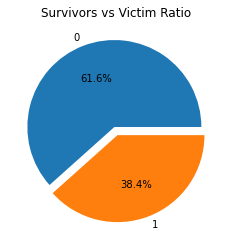

In [24]:
plt.pie(cleaned_data['Survived'].value_counts(), labels=cleaned_data['Survived'].unique(), explode=(0.05,0.05),autopct='%1.1f%%')
plt.title('Survivors vs Victim Ratio')
plt.show()

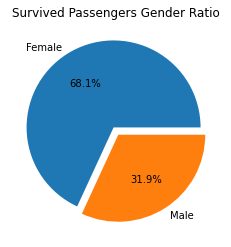

In [25]:
plt.pie(cleaned_data[cleaned_data['Survived']==1]['Sex_mapped'].value_counts(), labels=['Female', 'Male'], explode=(0.05,0.05),autopct='%1.1f%%')
plt.title('Survived Passengers Gender Ratio')
plt.show()

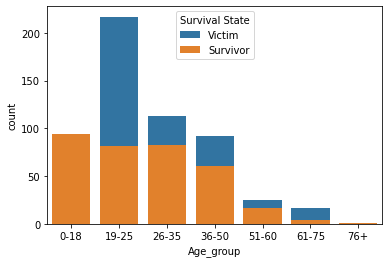

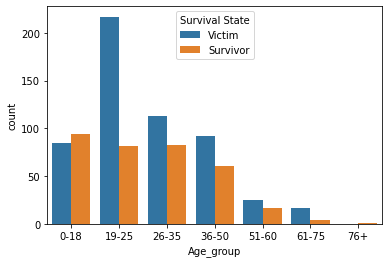

In [26]:
sns.countplot(data=cleaned_data, x='Age_group', hue='Survived', dodge=False, )
plt.legend(title='Survival State', labels=['Victim', 'Survivor'])
plt.show()

sns.countplot(data=cleaned_data, x='Age_group', hue='Survived', dodge=True,)
plt.legend(title='Survival State', labels=['Victim', 'Survivor'])
plt.show()

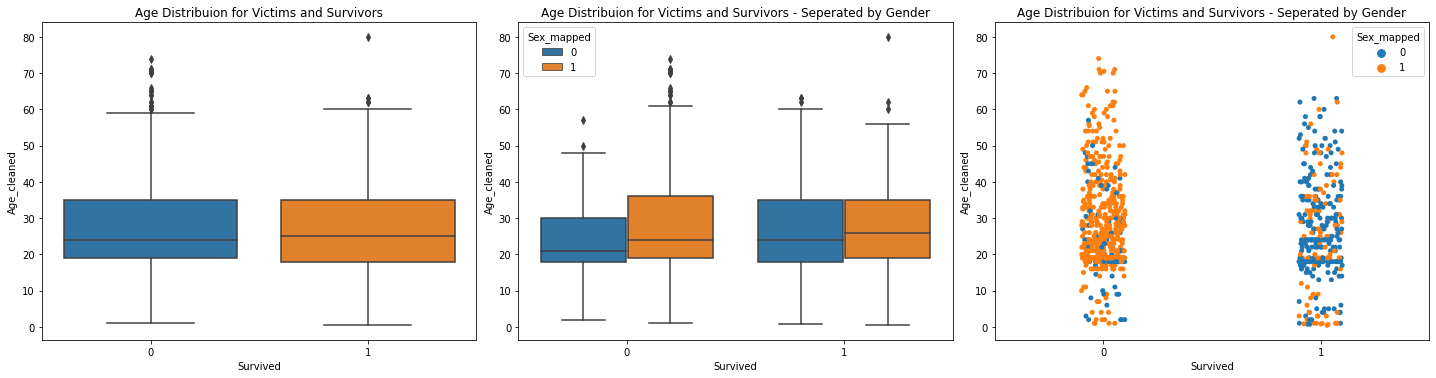

In [27]:
fig, (ax1,ax2,ax3)=plt.subplots(nrows=1, ncols=3, figsize=(20,5))
plt.tight_layout()

sns.boxplot(x='Survived', y='Age_cleaned', data=cleaned_data, ax=ax1)
ax1.set_title("Age Distribuion for Victims and Survivors")

sns.boxplot(x='Survived', y='Age_cleaned', data=cleaned_data, hue='Sex_mapped', ax=ax2)
ax2.set_title("Age Distribuion for Victims and Survivors - Seperated by Gender")

sns.stripplot(x='Survived', y='Age_cleaned', data=cleaned_data, hue='Sex_mapped', ax=ax3)
ax3.set_title("Age Distribuion for Victims and Survivors - Seperated by Gender")
plt.show()

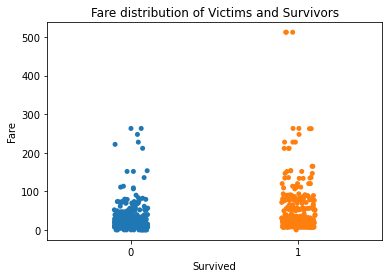

In [28]:
sns.stripplot(y='Fare', data=cleaned_data, x='Survived')
plt.title("Fare distribution of Victims and Survivors")
plt.show()

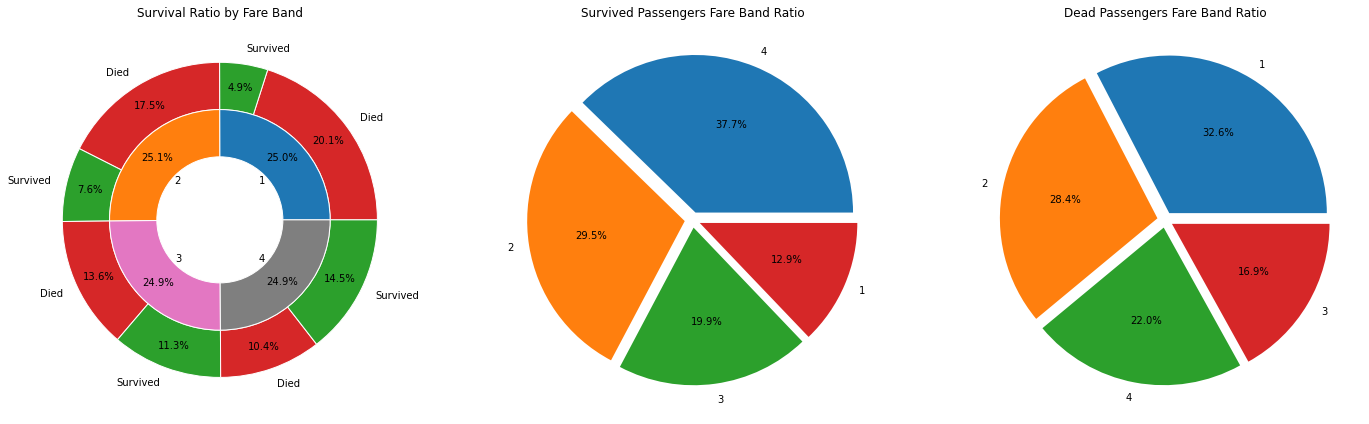

In [29]:
inner = cleaned_data.groupby('Fare_band')['Survived'].count()
outer = cleaned_data.groupby(['Fare_band','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink','tab:grey'])

ax1.set(aspect="equal", title='Survival Ratio by Fare Band')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Fare_band'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==1]['Fare_band'].unique(),explode=(0.05,0.05,0.05,0.05),autopct='%1.1f%%')
ax2.set_title('Survived Passengers Fare Band Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Fare_band'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==0]['Fare_band'].unique(),explode=(0.05,0.05,0.05,0.05),autopct='%1.1f%%')
ax3.set_title('Dead Passengers Fare Band Ratio')

plt.show()


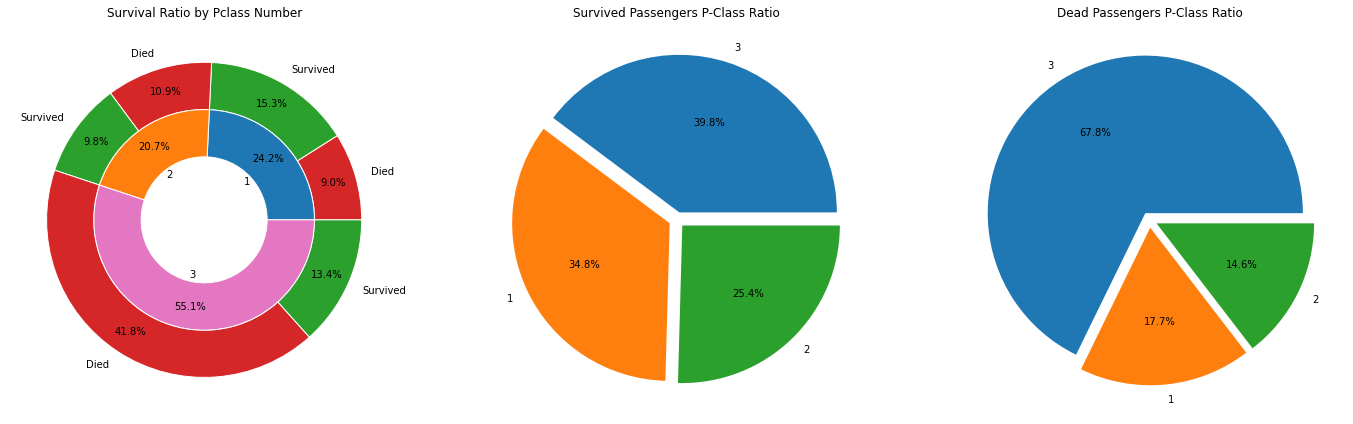

In [30]:
inner = cleaned_data.groupby('Pclass')['Survived'].count()
outer = cleaned_data.groupby(['Pclass','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink'])

ax1.set(aspect="equal", title='Survival Ratio by Pclass Number')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Pclass'].value_counts(), labels=cleaned_data['Pclass'].unique(), explode=(0.05,0.05,0.05),autopct='%1.1f%%')
ax2.set_title('Survived Passengers P-Class Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Pclass'].value_counts(), labels=cleaned_data['Pclass'].unique(), explode=(0.05,0.05,0.05),autopct='%1.1f%%')
ax3.set_title('Dead Passengers P-Class Ratio')
plt.show()

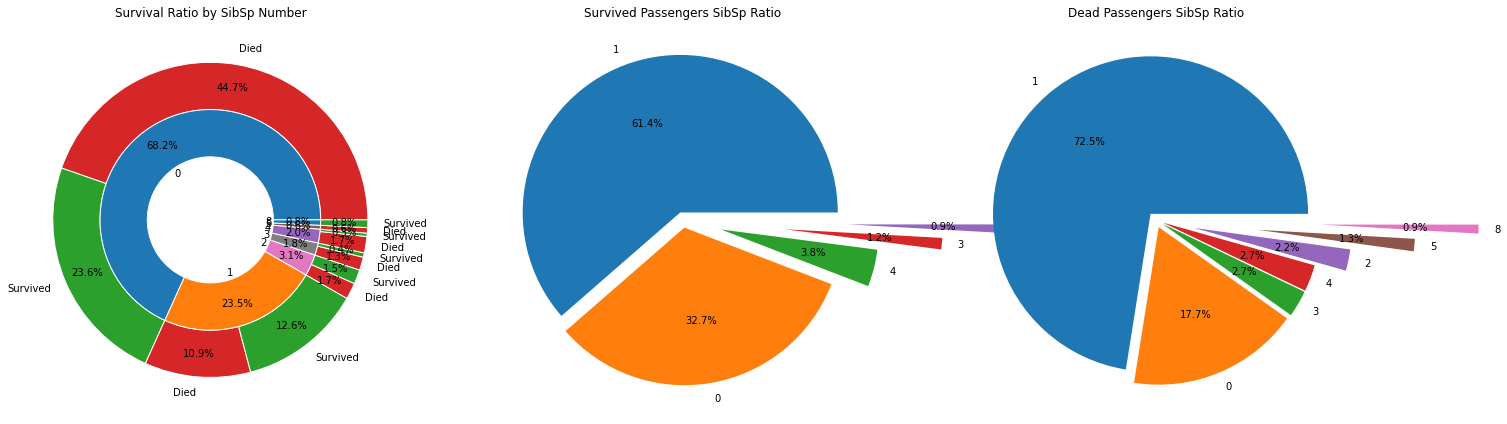

In [31]:
inner = cleaned_data.groupby('SibSp')['Survived'].count()
outer = cleaned_data.groupby(['SibSp','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink','tab:grey', 'tab:purple','tab:brown'])

ax1.set(aspect="equal", title='Survival Ratio by SibSp Number')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['SibSp'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==1]['SibSp'].unique(), explode=(0.05,0.05,0.25,0.65,1.05),autopct='%1.1f%%')
ax2.set_title('Survived Passengers SibSp Ratio')


ax3.pie(cleaned_data[cleaned_data['Survived']==0]['SibSp'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==0]['SibSp'].unique(),explode=(0.05,0.05,0.05,0.05,0.25,0.65,1.05) ,autopct='%1.1f%%')
ax3.set_title('Dead Passengers SibSp Ratio')
plt.show()


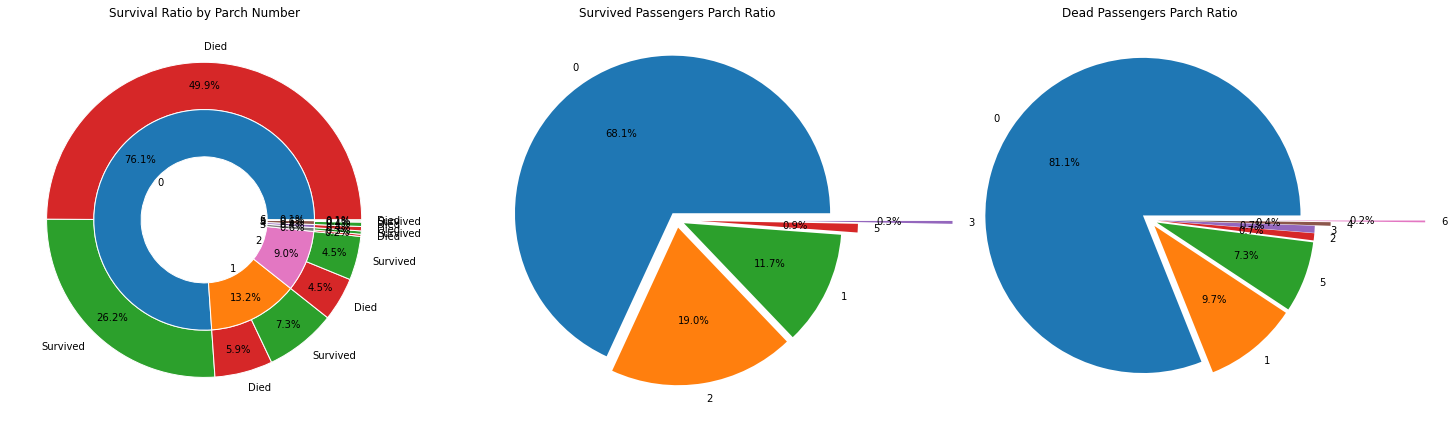

In [32]:
inner = cleaned_data.groupby('Parch')['Survived'].count()
outer = cleaned_data.groupby(['Parch','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Died','Survived','Died'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink','tab:grey', 'tab:purple','tab:brown', 'tab:olive'])

ax1.set(aspect="equal", title='Survival Ratio by Parch Number')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Parch'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==1]['Parch'].unique(),explode=(0.05,0.05,0.05,0.15,0.75),autopct='%1.1f%%')
ax2.set_title('Survived Passengers Parch Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Parch'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==0]['Parch'].unique(),explode=(0.05,0.05,0.05,0.05,0.05,0.15,0.75),autopct='%1.1f%%')
ax3.set_title('Dead Passengers Parch Ratio')
plt.show()


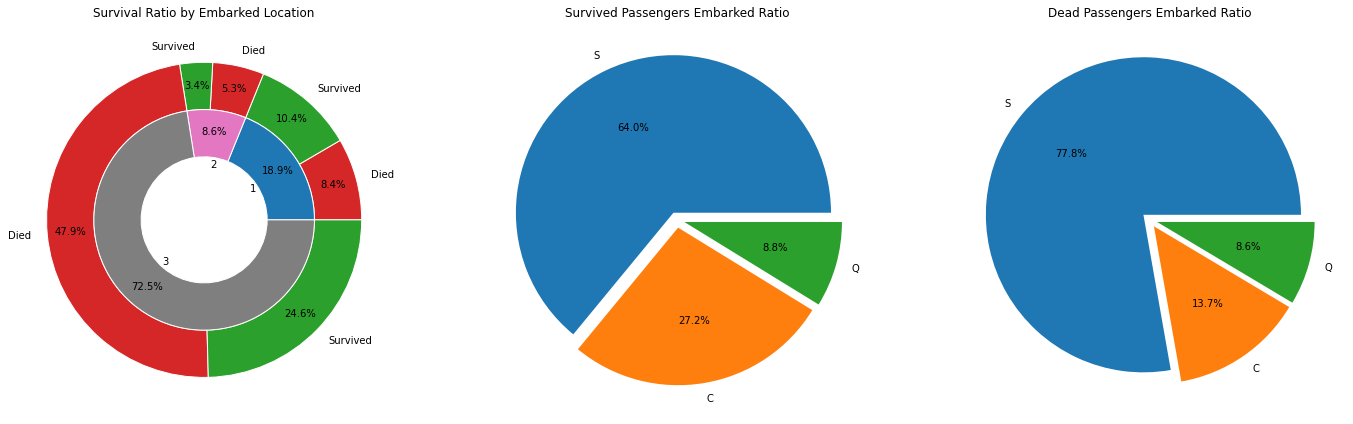

In [33]:
inner = cleaned_data.groupby('Embarked_mapped')['Survived'].count()
outer = cleaned_data.groupby(['Embarked_mapped','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:pink','tab:grey'])

ax1.set(aspect="equal", title='Survival Ratio by Embarked Location')


ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Embarked_mapped'].value_counts(), labels=model_data['Embarked'].unique(),explode=(0.05,0.05,0.05),autopct='%1.1f%%')
ax2.set_title('Survived Passengers Embarked Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Embarked_mapped'].value_counts(), labels=model_data['Embarked'].unique(),explode=(0.05,0.05,0.05),autopct='%1.1f%%')
ax3.set_title('Dead Passengers Embarked Ratio')
plt.show()


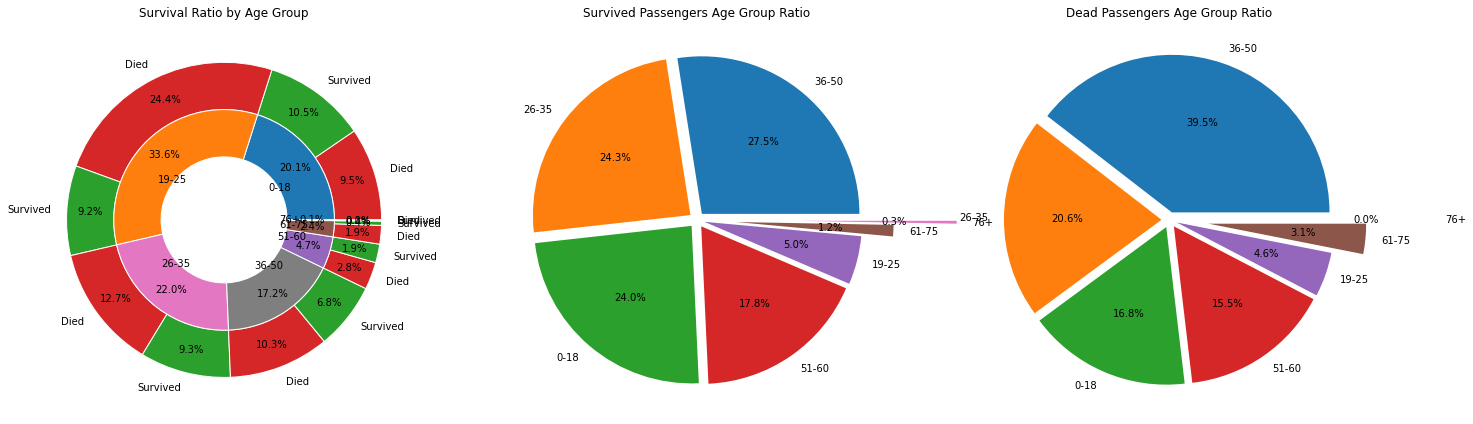

In [34]:
inner = cleaned_data.groupby('Age_group')['Survived'].count()
outer = cleaned_data.groupby(['Age_group','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= inner.index.get_level_values(0)
# inner_labels

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink','tab:grey', 'tab:purple','tab:brown', 'tab:olive'])

ax1.set(aspect="equal", title='Survival Ratio by Age Group')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Age_group'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==1]['Age_group'].unique(),explode=(0.05,0.05,0.05,0.05,0.05,0.25,0.65),autopct='%1.1f%%')
ax2.set_title('Survived Passengers Age Group Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Age_group'].value_counts(), labels=cleaned_data[cleaned_data['Survived']==1]['Age_group'].unique(),explode=(0.05,0.05,0.05,0.05,0.05,0.25,0.65),autopct='%1.1f%%')
ax3.set_title('Dead Passengers Age Group Ratio')
plt.show()



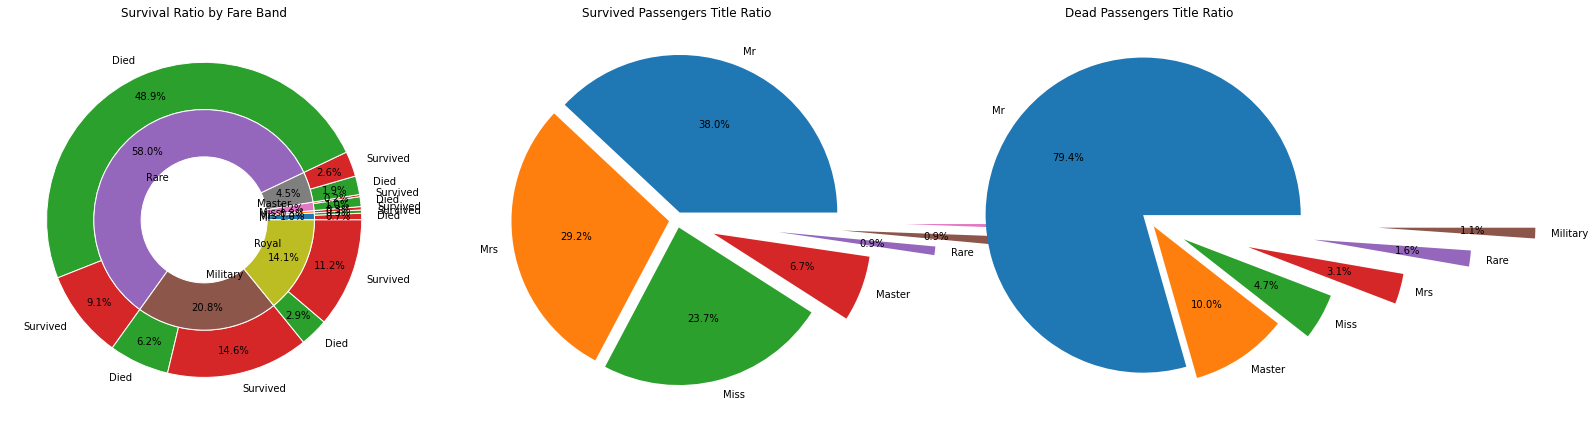

In [35]:
inner = cleaned_data.groupby('Title_mapped')['Survived'].count()
outer = cleaned_data.groupby(['Title_mapped','Survived'])['Survived'].count()
# print(inner)
# print(outer)

outer.values.flatten()
inner_labels= model_data['Title_cat'].unique()
# inner_labels


fig, (ax1,ax2,ax3) = plt.subplots(figsize=(24,12), nrows=1, ncols=3)
size = 0.3

ax1.pie(outer.values.flatten(), radius=1,labels = ['Died','Survived','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived','Died','Survived'],
           autopct='%1.1f%%',pctdistance=.85, labeldistance=1.1,colors=['tab:red','tab:green'],
       wedgeprops=dict(width=size, edgecolor='w'))

ax1.pie(inner.values.flatten(), radius=1-size,labels=inner_labels,autopct='%1.1f%%',pctdistance=.8, labeldistance=.5,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['tab:blue','tab:orange','tab:pink','tab:grey', 'tab:purple','tab:brown', 'tab:olive'])

ax1.set(aspect="equal", title='Survival Ratio by Fare Band')

ax2.pie(cleaned_data[cleaned_data['Survived']==1]['Title_mapped'].value_counts(), labels=model_data['Title_cat'].unique(),explode=(0.05,0.05,0.05,0.25,.65,1.05,1.45),autopct='%1.1f%%')
ax2.set_title('Survived Passengers Title Ratio')

ax3.pie(cleaned_data[cleaned_data['Survived']==0]['Title_mapped'].value_counts(), labels=model_data[model_data['Survived']==0]['Title_cat'].unique(),explode=(0.05,0.05,0.25,.65,1.05,1.45),autopct='%1.1f%%')
ax3.set_title('Dead Passengers Title Ratio')
plt.show()

# Getting Data for ML Model Building

#### Creating a new data set for model building with useful columns

In [36]:
model_data_cleaned = cleaned_data[['Pclass', 'Sex_mapped', 'SibSp', 'Parch', 'Embarked_mapped','Title_mapped','Fare_band','Age_group_mapped','Survived']]
model_data_cleaned

,Pclass,Sex_mapped,SibSp,Parch,Embarked_mapped,Title_mapped,Fare_band,Age_group_mapped,Survived
0,3,1,1,0,3,4,1,1,0
1,1,0,1,0,1,6,4,3,1
2,3,0,0,0,3,5,2,2,1
3,1,0,1,0,3,6,4,2,1
4,3,1,0,0,3,4,2,2,0
...,...,...,...,...,...,...,...,...,...
886,2,1,0,0,3,2,2,2,0
887,1,0,0,0,3,5,3,1,1
888,3,0,1,2,3,5,3,0,0
889,1,1,0,0,1,4,3,2,1


#### Seperating x and y i.e. features and target variables

In [37]:
x=model_data_cleaned.drop(columns=["Survived"])
y=model_data_cleaned[['Survived']]

#### Splitting dataset into training and testing datasets

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

# Training and Testing The Models

#### This is essentially a classification problem - so it is evident that we will make use of classifier algorithms such as KNN (k-nearest neighbor), Decision Tree, Random Forest and Extra Trees.

In [39]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

classifiers = {"RandomForestClassifier": RandomForestClassifier(), "KNeighborsClassifier": KNeighborsClassifier(),"DecisionTreeClassifier":DecisionTreeClassifier(), "ExtraTreesClassifier":ExtraTreesClassifier()}

for key, classifier in classifiers.items():

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = classifier
    model.fit(x_train, y_train) 
    
    start_time = time.time()
    y_pred=model.predict(x_test)
    end_time = time.time()

    print('\033[4m\033[1m' + key + '\033[0m')
    print("{0} took {1} s, its accuracy score is {2}, and its F1-Score is {3}".format(key,round(end_time - start_time,2), round(metrics.accuracy_score(y_test,y_pred),2), round(metrics.f1_score(y_test,y_pred),2)))
    print("---"*30)

RandomForestClassifier
RandomForestClassifier took 0.01 s, its accuracy score is 0.82, and its F1-Score is 0.76
------------------------------------------------------------------------------------------
KNeighborsClassifier
KNeighborsClassifier took 0.0 s, its accuracy score is 0.87, and its F1-Score is 0.82
------------------------------------------------------------------------------------------
DecisionTreeClassifier
DecisionTreeClassifier took 0.0 s, its accuracy score is 0.84, and its F1-Score is 0.78
------------------------------------------------------------------------------------------
ExtraTreesClassifier
ExtraTreesClassifier took 0.0 s, its accuracy score is 0.84, and its F1-Score is 0.77
------------------------------------------------------------------------------------------


C:\Users\Maanas\AppData\Local\Temp\ipykernel_24612\4182974655.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Maanas\AppData\Local\Temp\ipykernel_24612\4182974655.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


In [40]:
print('Essential Part of Project Complete!')

Essential Part of Project Complete!


# Extensions

## Feature Selection

### Mutual Information Method:

C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


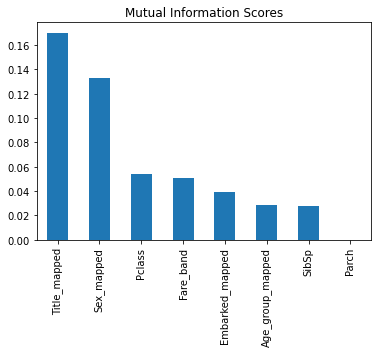

In [41]:
from sklearn.feature_selection import mutual_info_classif

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

mi_scores = mutual_info_classif(x_train, y_train, n_neighbors=5)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns).sort_values(ascending=False)

mi_scores.plot.bar()
plt.title('Mutual Information Scores')
plt.show()

### Univariate Selection Method:

C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


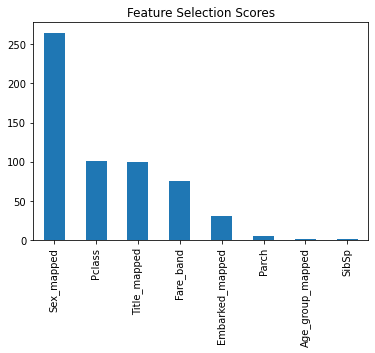

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

selector = SelectKBest(score_func=f_classif, k=4) #4 best features
fit = selector.fit(x_train, y_train)

selected_features_identifier = selector.get_support()

selected_features = x_train.columns[selected_features_identifier]
selected_features_identifier

# print("The selected features are:", selected_features)

selector_scores = pd.Series(fit.scores_, name="Feature Selection Scores", index=x_train.columns).sort_values(ascending=False)

selector_scores.plot.bar()
plt.title('Feature Selection Scores')
plt.show()

### Recursive Feature Elimination

#### with Random Forest Classifier

In [43]:
from sklearn.feature_selection import RFE

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rfe = RFE(estimator=RandomForestClassifier(),n_features_to_select=1) #to get the ranking of features, we will set n_features_to_select to 1 as this is how RFE works
fit = rfe.fit(x_train, y_train)
ranked_features = pd.Series(fit.ranking_, name="RFE Ranking with Random Forest", index=x_train.columns).sort_values(ascending=True)
print("Feature Rankings: \n%s" % ranked_features)

# print("Number of Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)

C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when

Feature Rankings: 
Title_mapped        1
Pclass              2
Sex_mapped          3
Age_group_mapped    4
Fare_band           5
SibSp               6
Embarked_mapped     7
Parch               8
Name: RFE Ranking with Random Forest, dtype: int32


C:\Users\Maanas\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)


#### with Decision Tree Classifier

In [44]:
from sklearn.feature_selection import RFE

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rfe = RFE(estimator=DecisionTreeClassifier(),n_features_to_select=1) #to get the ranking of features, we will set n_features_to_select to 1 as this is how RFE works
fit = rfe.fit(x_train, y_train)
ranked_features = pd.Series(fit.ranking_, name="RFE Ranking with Decision Trees", index=x_train.columns).sort_values(ascending=True)
print("Feature Rankings: \n%s" % ranked_features)

# print("Number of Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)

Feature Rankings: 
Sex_mapped          1
Pclass              2
Age_group_mapped    3
Fare_band           4
SibSp               5
Embarked_mapped     6
Title_mapped        7
Parch               8
Name: RFE Ranking with Decision Trees, dtype: int32


### Feature Importance Method

#### with Random Forest Classifier

C:\Users\Maanas\AppData\Local\Temp\ipykernel_24612\765811687.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


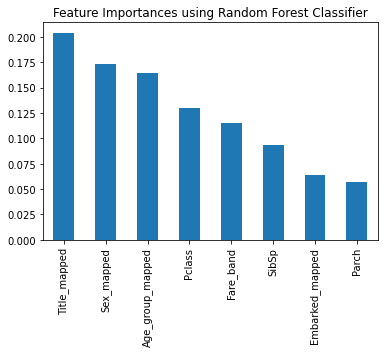

In [45]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(x_train,y_train)
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=x_train.columns).sort_values(ascending=False)

forest_importances.plot.bar()
plt.title('Feature Importances using Random Forest Classifier')
plt.show()

#### with Decision Tree Classifier

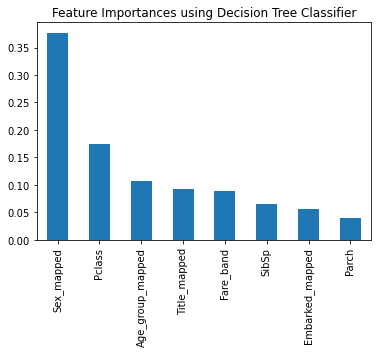

In [46]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = DecisionTreeClassifier()
model.fit(x_train,y_train)
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=x_train.columns).sort_values(ascending=False)

forest_importances.plot.bar()
plt.title('Feature Importances using Decision Tree Classifier')
plt.show()

# Finding Most Optimal ML Model Using Lazy Predict

In [47]:
from lazypredict.Supervised import LazyClassifier 
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

clf_model, clf_prediction= clf.fit(x_train, x_test, y_train, y_test)
print(clf_model)
print("---------")
print(clf_prediction)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 14.84it/s]

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

# Hyperparameter Tuning - Random Forest Classifier

### Creating a function to evaluate the models; 

In [48]:
def model_evaluation(model, x_test, y_test):

    start_time = time.time()
    pred = model.predict(x_test)
    end_time = time.time()

    accuracy = metrics.accuracy_score(y_test,pred)*100
    f1_score = metrics.f1_score(y_test,pred)*100
    time_taken = round(end_time - start_time,2)

    print('\033[4m\033[1m',model,'\033[0m')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('F1-Score = {:0.2f}%.'.format(f1_score))
    print('Time taken = {:0.2f}s.'.format(time_taken))
    
    return accuracy, f1_score

### Base case - no tuning

In [49]:
rf_base = RandomForestClassifier(random_state=0)
rf_base.fit(x_train, y_train)

start_time = time.time()
y_pred=rf_base.predict(x_test)
end_time = time.time()

# print('\033[4m\033[1m',rf_base,'\033[0m')
# print("{0} took {1} s, its accuracy score is {2}, and its F1-Score is {3}".format(key,round(end_time - start_time,2), round(metrics.accuracy_score(y_test,y_pred),2), round(metrics.f1_score(y_test,y_pred),2)))
# print("---"*30)

rf_base_accuracy, rf_base_f1_score = model_evaluation(rf_base, x_test, y_test)

 RandomForestClassifier(random_state=0) 
Accuracy = 83.80%.
F1-Score = 77.52%.
Time taken = 0.01s.


#### Get current params

In [51]:
rf_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### Find ballpark of best params using Random Search with Cross Validation

we will play around with n_estimators (no of trees), max_depth (no of levels in tree), max_features (no of features at every split), min_samples_split (no of samples needed to split a node), min_samples_leaf (no of samples needed at each leaf node), bootstrap (method of selecting samples for each tree)

In [52]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(0,2000,10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(0,200,10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.arange(0,20,1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(0,20,10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1

### Random search of parameters, using 3 fold cross validation, across 50 different combinations and using all cores

In [54]:
rf_random = RandomizedSearchCV(estimator=rf_base, param_distributions=random_grid,
                              n_iter = 50, #scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=0, n_jobs=-1,)
                              #return_train_score=True)

# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 10],
                                        'min_samples_split': [0, 1, 2, 3, 4, 5,
                                                              6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15, 16, 17, 18,
                                               

#### Finding best params from the Random Search

In [55]:
rf_random.best_params_

{'n_estimators': 350,
 'min_samples_split': 14,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

#### Using these params and evaluating model

In [56]:
best_random = rf_random.best_estimator_
rf_best_random_accuracy, rf_best_random_f1_score = model_evaluation(best_random, x_test, y_test)

 RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=14,
                       n_estimators=350, random_state=0) 
Accuracy = 85.47%.
F1-Score = 78.33%.
Time taken = 0.02s.


#### Improvement to accuracy when using the best params from the Random Search

In [57]:
print('Accuracy Improvement of {:0.2f}%.'.format( 100 * (rf_best_random_accuracy - rf_base_accuracy) / rf_base_accuracy))
print('F1-Score Improvement of {:0.2f}%.'.format( 100 * (rf_best_random_f1_score - rf_base_f1_score) / rf_base_f1_score))


Accuracy Improvement of 2.00%.
F1-Score Improvement of 1.05%.


### Now performing a GridSearch with a smaller range for each of the params

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [False],
    'max_depth':np.arange(30,70,5), #+- 20
    'max_features': ['sqrt'], #fixed
    'min_samples_leaf': np.arange(8,10,1), #+- 2
    'min_samples_split': np.arange(12,16,1), #+-2
    'n_estimators': np.arange(330,370,5) #+-20
}

rf_grid_search = GridSearchCV(estimator = rf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, )#return_train_score=True)

rf_grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': array([30, 35, 40, 45, 50, 55, 60, 65]),
                         'max_features': ['sqrt'],
                         'min_samples_leaf': array([8, 9]),
                         'min_samples_split': array([12, 13, 14, 15]),
                         'n_estimators': array([330, 335, 340, 345, 350, 355, 360, 365])},
             verbose=2)

#### Finding best params from the Grid Search

In [74]:
rf_grid_search.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 12,
 'n_estimators': 350}

#### Using these params and evaluating model

In [75]:
best_grid = rf_grid_search.best_estimator_
rf_best_grid_accuracy, rf_best_grid_f1_score = model_evaluation(best_grid, x_test, y_test)

 RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=12,
                       n_estimators=350, random_state=0) 
Accuracy = 86.59%.
F1-Score = 80.33%.
Time taken = 0.04s.


#### Improvement to accuracy when using the best params from the Grid Search

In [76]:
print('Accuracy Improvement of {:0.2f}%.'.format( 100 * (rf_best_grid_accuracy - rf_base_accuracy) / rf_base_accuracy))
print('F1-Score Improvement of {:0.2f}%.'.format( 100 * (rf_best_grid_f1_score - rf_base_f1_score) / rf_base_f1_score))


Accuracy Improvement of 3.33%.
F1-Score Improvement of 3.62%.


### Re-performing the GridSearch with a different range for each of the params

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid2 = {
    'bootstrap': [False],
    'max_depth':np.arange(20,40,2), #+- 10
    'max_features': ['sqrt'], #fixed
    'min_samples_leaf': np.arange(4,12,1), #+- 4
    'min_samples_split': np.arange(12,16,1), #+-4
    'n_estimators': np.arange(340,360,2) #+-20
}

rf_grid_search2 = GridSearchCV(estimator = rf_base, param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 2, )#return_train_score=True)

rf_grid_search2.fit(x_train, y_train)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38]),
                         'max_features': ['sqrt'],
                         'min_samples_leaf': array([ 4,  5,  6,  7,  8,  9, 10, 11]),
                         'min_samples_split': array([12, 13, 14, 15]),
                         'n_estimators': array([340, 342, 344, 346, 348, 350, 352, 354, 356, 358])},
             verbose=2)

#### Finding best params from the Grid Search

In [78]:
rf_grid_search2.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 12,
 'n_estimators': 342}

#### Using these params and evaluating model

In [79]:
best_grid2 = rf_grid_search2.best_estimator_
rf_best_grid_accuracy2, rf_best_grid_f1_score2 = model_evaluation(best_grid2, x_test, y_test)

 RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=12,
                       n_estimators=342, random_state=0) 
Accuracy = 85.47%.
F1-Score = 78.33%.
Time taken = 0.02s.


#### Improvement to accuracy when using the best params from the Grid Search

In [80]:
print('Accuracy Improvement of {:0.2f}%.'.format( 100 * (rf_best_grid_accuracy2 - rf_base_accuracy) / rf_base_accuracy))
print('F1-Score Improvement of {:0.2f}%.'.format( 100 * (rf_best_grid_f1_score2 - rf_base_f1_score) / rf_base_f1_score))


Accuracy Improvement of 2.00%.
F1-Score Improvement of 1.05%.


In [81]:
print('Project Complete!')

Project Complete!


labels = ['0-18', '19-25', '26-35', '36-50', '51-60', '61-75', '76+']
bins=[0,18,25,35,50,60,75,100] #lower and upper bounds included
cleaned_data['Age_group'] = pd.cut(cleaned_data['Age_cleaned'],bins,labels)

cleaned_data.groupby(['Age_group','Survived']).size().unstack().reset_index().plot(kind='bar',stacked=True)
plt.xlabel('Age Group')
locs, xticks_labels = plt.xticks()
plt.xticks(locs, labels, rotation=0)
plt.ylabel('Count')
plt.title('Age Distribution - Seperated by Survival State')
plt.legend(title='Survival State', labels=['Victim', 'Survivor'])
plt.show()

cleaned_data.groupby(['Age_group','Survived']).size().unstack().reset_index().plot(kind='bar',stacked=False)
plt.xlabel('Age Group')
locs, xticks_labels = plt.xticks()
plt.xticks(locs, labels, rotation=0)
plt.ylabel('Count')
plt.title('Age Distribution - Seperated by Survival State')
plt.legend(title='Survival State', labels=['Victim', 'Survivor'])
plt.show()